# Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.dates import DateFormatter
from matplotlib import dates
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
import warnings
import holidays
from scipy import stats
import calendar
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
warnings.filterwarnings('ignore')

## Graphical parameter setting

In [ ]:
## parameter setting for graphs
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

# Functions

In [4]:
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
            
### K fold target encoding for training test
class KFoldTargetEncoderTrain(BaseEstimator,TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=2019)



        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return(X)
    
### K Fold target encoding for test set
class KFoldTargetEncoderTest(BaseEstimator, TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
    
        return(X)

## correlation of multivariate analysis    
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
## Traffic data feature manipulation
def lag1_mean(x):
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("30min"),x - pd.Timedelta("20min"),freq ='min'),"Traffic.Ordinal"].mean()
    return(val)

def lag2_mean(x):
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("40min"),x - pd.Timedelta("30min"),freq ='min'),"Traffic.Ordinal"].mean()
    return(val)

def lag3_mean(x):
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:43:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("50min"),x - pd.Timedelta("40min"),freq ='min'),"Traffic.Ordinal"].mean()
    return(val)

def lag4_mean(x):
    val = np.nan
    if x >=pd.Timestamp('2016-08-28 07:53:00'):
        val = traffic.loc[pd.date_range(x - pd.Timedelta("60min"),x - pd.Timedelta("50min"),freq ='min'),"Traffic.Ordinal"].mean()
    return(val)

In [6]:
## load data
train = pd.read_csv("train_update.csv")
vancouver = pd.read_csv("vancouver_update.csv")
victoria = pd.read_csv("victoria_update.csv")
traffic = pd.read_csv("traffic_clean.csv")
test = pd.read_csv("test.csv")

In [5]:
## encode test and training set
train.drop(["Unnamed: 0","Status"],axis=1,inplace = True)

test["Delay.Indicator"] = np.nan
test.drop("ID",axis = 1,inplace = True)

In [7]:
traffic.rename(columns = {"Unnamed: 0":"Date"},inplace = True)
vancouver.drop(["Unnamed: 0"],axis = 1,inplace = True)

# Exploratory data analysis

## Train

In [16]:
train

,Vessel.Name,Scheduled.Departure,Trip,Day,Month,Day.of.Month,Year,Full.Date,Delay.Indicator,Vessel.Name_Kfold_Target_Enc,Trip_Kfold_Target_Enc,weekend.Indicator,Date_time,holidays_indicator
0,Spirit of British Columbia,07:00,Tsawwassen to Swartz Bay,6,8,28,2016,2016-08-28,0,0.202073,0.156044,True,2016-08-28 07:00:00,False
1,Queen of New Westminster,08:00,Tsawwassen to Swartz Bay,6,8,28,2016,2016-08-28,0,0.117647,0.156044,True,2016-08-28 08:00:00,False
2,Spirit of Vancouver Island,09:00,Tsawwassen to Swartz Bay,6,8,28,2016,2016-08-28,0,0.171150,0.156044,True,2016-08-28 09:00:00,False
3,Coastal Celebration,10:00,Tsawwassen to Swartz Bay,6,8,28,2016,2016-08-28,0,0.159859,0.156044,True,2016-08-28 10:00:00,False
4,Spirit of British Columbia,11:00,Tsawwassen to Swartz Bay,6,8,28,2016,2016-08-28,0,0.202073,0.156044,True,2016-08-28 11:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49499,Coastal Celebration,13:00,Swartz Bay to Tsawwassen,0,11,27,2017,2017-11-27,0,0.154498,0.169185,False,2017-11-27 13:00:00,False
49500,Spirit of Vancouver Island,15:00,Swartz Bay to Tsawwassen,0,11,27,2017,2017-11-27,1,0.194069,0.169185,False,2017-11-27 15:00:00,False
49501,Coastal Celebration,17:00,Swartz Bay to Tsawwassen,0,11,27,2017,2017-11-27,0,0.154498,0.169185,False,2017-11-27 17:00:00,False
49502,Spirit of Vancouver Island,19:00,Swartz Bay to Tsawwassen,0,11,27,2017,2017-11-27,1,0.194069,0.169185,False,2017-11-27 19:00:00,False


### Target encoding of major categorical variables

In [17]:
## Encode Vessel.Name
targetc = KFoldTargetEncoderTrain('Vessel.Name','Delay.Indicator',n_fold=5)
train = targetc.fit_transform(train)
test_targetc = KFoldTargetEncoderTest(train,
                                      'Vessel.Name',
                                      'Vessel.Name_Kfold_Target_Enc')
test = test_targetc.fit_transform(test)

## Encode Vessel.Name
targetc = KFoldTargetEncoderTrain('Trip','Delay.Indicator',n_fold=5)
train = targetc.fit_transform(train)
test_targetc = KFoldTargetEncoderTest(train,
                                      'Trip',
                                      'Trip_Kfold_Target_Enc')
test = test_targetc.fit_transform(test)


Correlation between the new feature, Vessel.Name_Kfold_Target_Enc and, Delay.Indicator is 0.14538710199757263.
Correlation between the new feature, Trip_Kfold_Target_Enc and, Delay.Indicator is 0.13333638368739953.



----------------Distribution of class label----------------



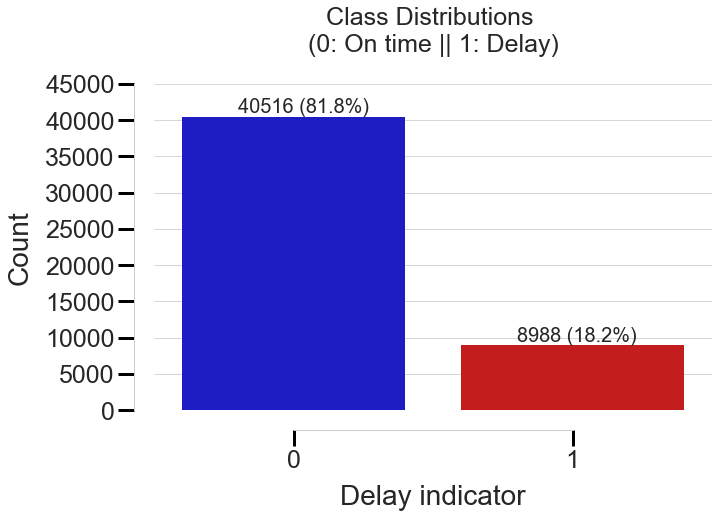

In [18]:
print('\n----------------Distribution of class label----------------\n')
plt.figure(figsize=(10,6))
colors = ["#0101DF", "#DF0101"]
ax = sns.countplot('Delay.Indicator', data=train, palette=colors)

total = len(train['Delay.Indicator'])
## set count and percentage labels above bars
for p in ax.patches:
        percentage = '{} ({:.1f}%)'.format(p.get_height(),100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/4 
        y = p.get_y() + p.get_height()+500
        ax.annotate(percentage, (x, y),size = 20)

ax.set_xlabel("Delay indicator",size = 28,labelpad=12)
ax.set_ylabel("Count",size = 28,labelpad=12)
ax.set_yticks([5000*i for i in range(10)])


ax.spines['bottom'].set_bounds(0, 1)
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_title('Class Distributions \n (0: On time || 1: Delay) \n', fontsize=25)
adjust_spines(ax, ['left', 'bottom'])


plt.show()

### Important date features extraction

In [19]:
## train: Feature extraction
train["Full.Date"] = pd.to_datetime(train["Full.Date"])
train["Month"]=pd.Series(pd.DatetimeIndex(train["Full.Date"]).month)
train["Day"] = train["Full.Date"].apply(lambda x: x.dayofweek)
train["weekend.Indicator"] = train["Day"]//5 ==1 

## train: Feature extraction
test["Full.Date"] = pd.to_datetime(test["Full.Date"])
test["Month"]=pd.Series(pd.DatetimeIndex(test["Full.Date"]).month)
test["Day"] = test["Full.Date"].apply(lambda x: x.dayofweek)
test["weekend.Indicator"] = test["Day"]//5 ==1 

In [20]:
## add a date column for train
train["Date_time"] = pd.to_datetime(train["Full.Date"].astype("str") +" "+ pd.to_datetime(train["Scheduled.Departure"]).apply(lambda x: x.strftime("%H:%M:%S")).astype("str"))
test["Date_time"] = pd.to_datetime(test["Full.Date"].astype("str") +" "+ pd.to_datetime(test["Scheduled.Departure"]).apply(lambda x: x.strftime("%H:%M:%S")).astype("str"))

## holiday indicator for train
train["holidays_indicator"] = train["Date_time"].apply(lambda x:x in holidays.CA())

## holiday indicator for test
test["holidays_indicator"] = test["Date_time"].apply(lambda x:x in holidays.CA())

#### Visualization of Year to the response

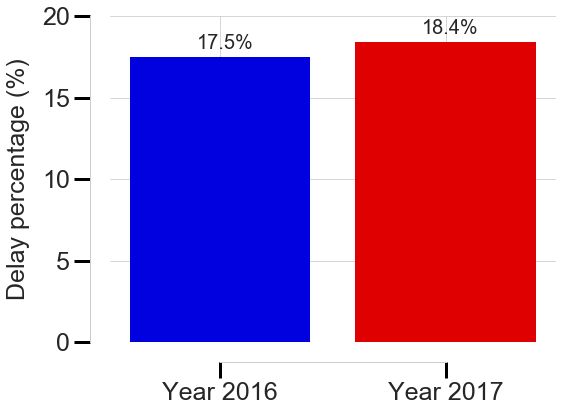

In [21]:
train_year = train[["Year","Delay.Indicator"]]
train_year = train_year.groupby("Year").mean().reset_index()
train_year['Year'] = train_year['Year'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
Year = [2016,2017]
#Year = ["Year 2016","Year 2017"]
Indicator = list(train_year["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(Year,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

        
ax.set_xticks(Year)
ax.set_xticklabels(['Year 2016', 'Year 2017'])

ax.spines['bottom'].set_bounds(2016, 2017)

ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Month related to the response

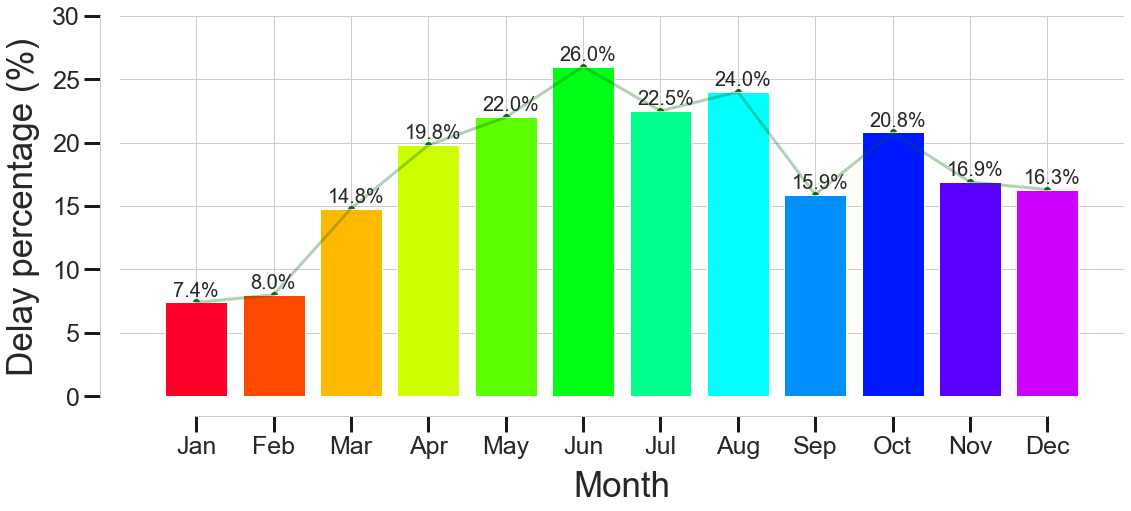

In [73]:
train_month = train[["Month","Delay.Indicator"]]
train_month = train_month.groupby("Month").mean().reset_index()
train_month['Month'] = train_month['Month'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(18,7))
NUM_COLORS = 12
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

Month = train_month['Month']
Month_str = train_month['Month'].apply(lambda x:calendar.month_abbr[x])
Indicator = list(train_month["Delay.Indicator"].apply(lambda x: round(x*100,1)))

ax.bar(Month,Indicator,color = colors)
ax.plot(Month,Indicator,alpha = 0.3,color = 'darkgreen',linewidth = "3")
ax.scatter(Month,Indicator,alpha = 0.9,color = 'darkgreen')
for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/8
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

ax.set_xticks(Month)
ax.set_xticklabels(Month_str)

ax.spines['bottom'].set_bounds(1,12)
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_yticks([i for i in range(0,31,5)])
ax.set_ylabel("Delay percentage (%)",size = 35,labelpad=12)
ax.set_xlabel("Month",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Time related to the response

In [74]:
Hour = [i for i in range(24) if i not in [1,2,3,4]]
Hour

[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

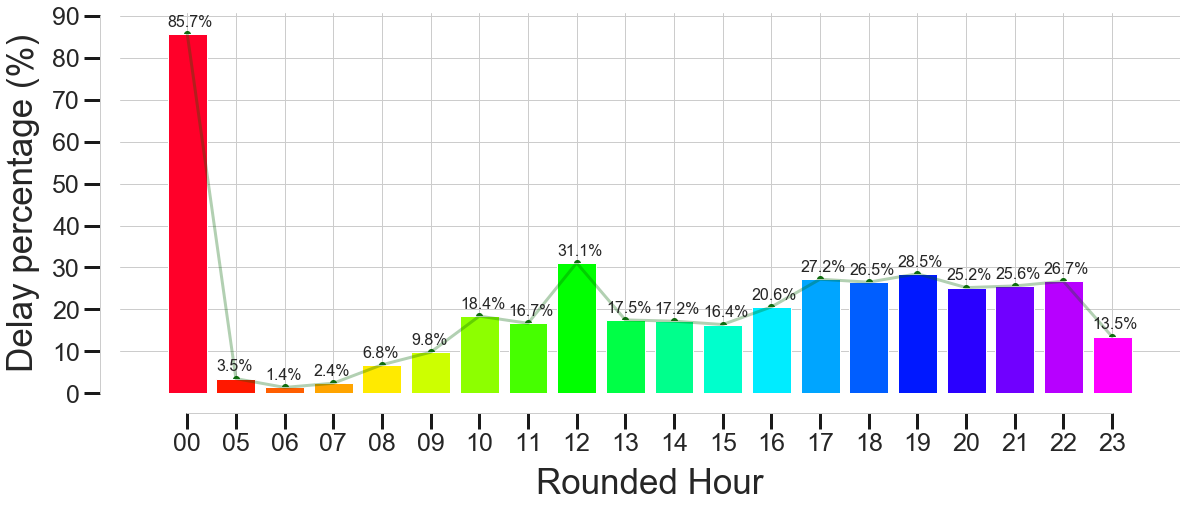

In [75]:
train_time = train[["Date_time","Delay.Indicator"]]
## round the whole time object up tl hour
train_time["Round_time"] = train_time["Date_time"].dt.round("H")
train_time["Round_Hour"] = train_time["Round_time"].apply(lambda x: x.strftime("%H"))

train_time = train_time[["Round_Hour","Delay.Indicator"]]
train_time = train_time.groupby("Round_Hour").mean().reset_index()
train_time['Round_Hour'] = train_time['Round_Hour'].astype('object')


fig, ax = plt.subplots(1,1,figsize=(19,7))
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

Hour_str = np.unique(train_time['Round_Hour'])
Hour = [i for i in range(20)]
Indicator = list(train_time["Delay.Indicator"].apply(lambda x: round(x*100,1)))

ax.set_xticks(Hour)
ax.set_xticklabels(Hour_str)

ax.spines['bottom'].set_bounds(0,19)
ax.bar(Hour,Indicator,color = colors)
ax.plot(Hour,Indicator,alpha = 0.3,color = 'darkgreen',linewidth = "3")
ax.scatter(Hour,Indicator,alpha = 0.9,color = 'darkgreen')
for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x()
        y = p.get_y() + p.get_height()+1.8
        ax.annotate(percentage, (x, y),size = 16)


ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_yticks([i for i in range(0,91,10)])
ax.set_ylabel("Delay percentage (%)",size = 35,labelpad=12)
ax.set_xlabel("Rounded Hour",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Weekend to the response

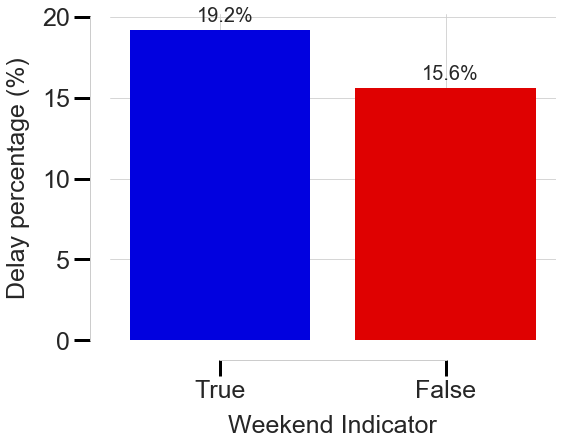

In [22]:
train_week = train[["weekend.Indicator","Delay.Indicator"]]
train_week = train_week.groupby("weekend.Indicator").mean().reset_index()
train_week['weekend.Indicator'] = train_week['weekend.Indicator'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
weekend = ["True","False"]
Indicator = list(train_week["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(weekend,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

        
Week = [0,1]       
Week_str = ["True","False"]
ax.set_xticks(Week)
ax.set_xticklabels(Week_str)

ax.spines['bottom'].set_bounds(0,1)        
        
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_xlabel("Weekend Indicator",size = 25,labelpad=12)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

#### Visualization of Holiday to the response

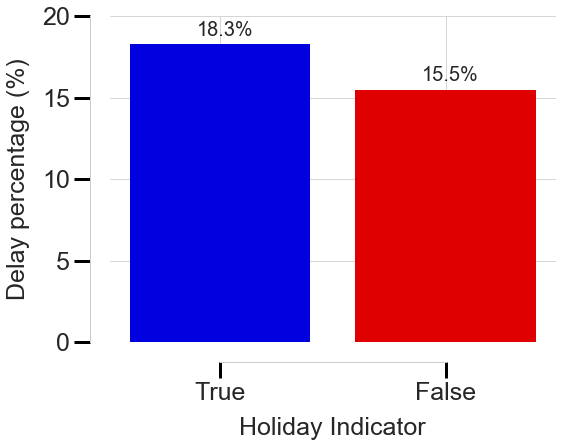

In [23]:
train_holiday = train[["holidays_indicator","Delay.Indicator"]]
train_holiday = train_holiday.groupby("holidays_indicator").mean().reset_index()
train_holiday['holidays_indicator'] = train_holiday['holidays_indicator'].astype('object')

fig, ax = plt.subplots(1,1,figsize=(8,6))

colors = ["#0101DF", "#DF0101"]
holiday = ["True","False"]
Indicator = list(train_holiday["Delay.Indicator"].apply(lambda x: round(100*x,1)))
ax.bar(holiday,Indicator,color = colors)

for p in ax.patches:
        percentage = '{}%'.format(p.get_height())
        x = p.get_x() + p.get_width()/2.7 
        y = p.get_y() + p.get_height()+0.5
        ax.annotate(percentage, (x, y),size = 20)

Holi = [0,1]       
Holi_str = ["True","False"]
ax.set_xticks(Holi)
ax.set_xticklabels(Holi_str)

ax.spines['bottom'].set_bounds(0,1)     
        
ax.tick_params(axis= "x",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.tick_params(axis= "y",direction = 'out',which='major', length=16,width=3, color='k',labelsize = 25)
ax.set_xlabel("Holiday Indicator",size = 25,labelpad=12)
ax.set_ylabel("Delay percentage (%)",size = 25,labelpad=12)
ax.set_yticks([i for i in range(0,21,5)])
adjust_spines(ax, ['left', 'bottom'])

## Vancouver

In [24]:
vancouver.drop("Humidex",axis=1,inplace = True)

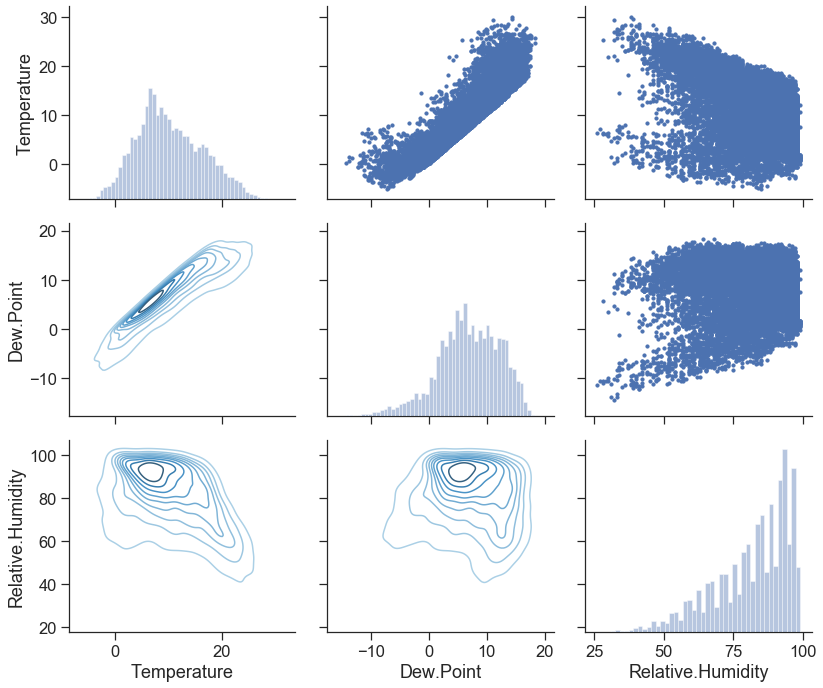

In [28]:
## pairplot
sns.set(style = "ticks", rc={'figure.figsize':(10,10),"xtick.major.size": 8, "ytick.major.size": 8},font_scale = 1.5)
vancouver["Month"] = vancouver["Year"].astype('object')

whe_dat = vancouver.loc[:,["Temperature","Dew.Point","Relative.Humidity"]]

g = sns.PairGrid(whe_dat, palette=["red"],height = 3.3,aspect = 1.2)

g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

## Victoria

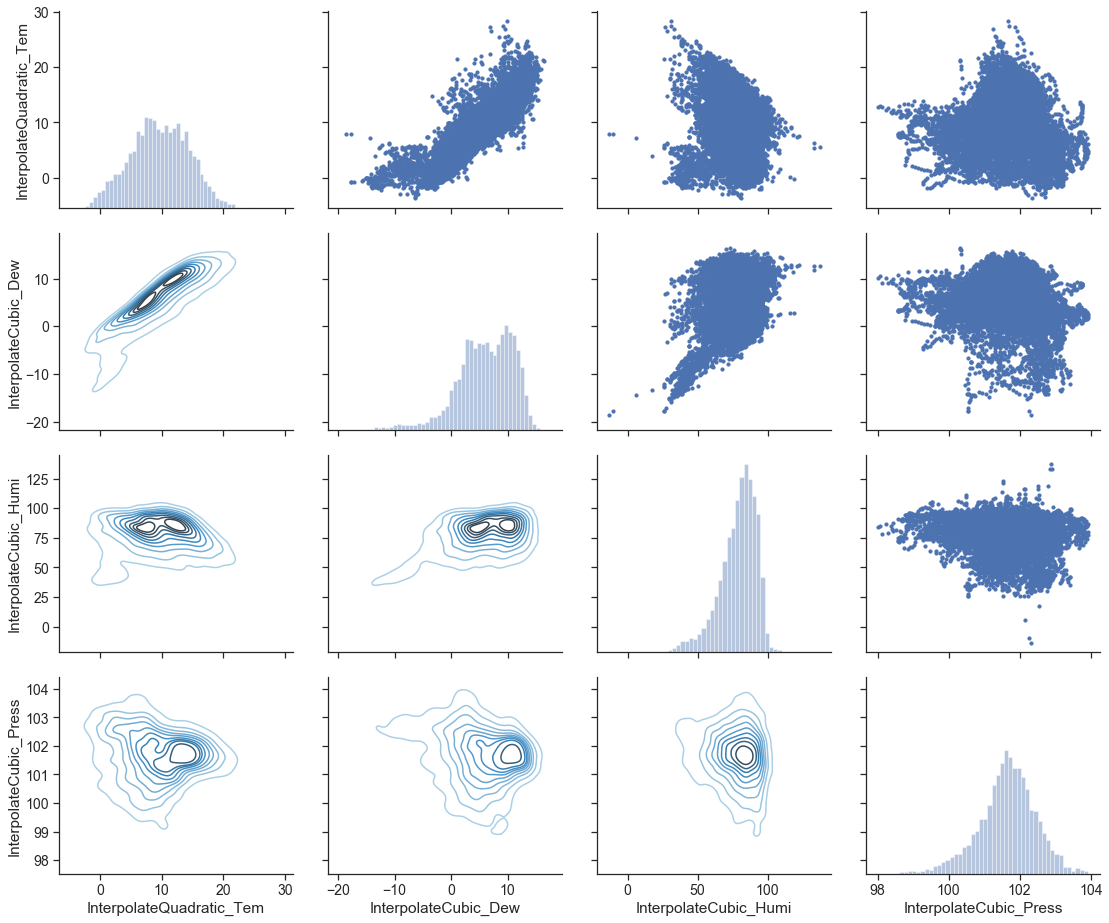

In [30]:
## pairplot
sns.set(style = "ticks", rc={'figure.figsize':(15,15)},font_scale = 1.28)
whe_dat = victoria.iloc[:,[7,9,10,11]]
whe_dat.dropna(axis =0,inplace = True)
g = sns.PairGrid(whe_dat, palette=["red"],height = 3.3,aspect = 1.2)

g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

# Feature seletion

## Vancouver

In [82]:
## temperature lags
vancouver['van_tem_lag1'] = vancouver['Temperature'].shift(1)
vancouver['van_tem_lag2'] = vancouver['Temperature'].shift(2)

## Dew.Point lags
vancouver['van_dew_lag1'] = vancouver['Dew.Point'].shift(1)
vancouver['van_dew_lag2'] = vancouver['Dew.Point'].shift(2)

## Relative.Humidity lags
vancouver['van_hum_lag1'] = vancouver['Relative.Humidity'].shift(1)
vancouver['van_hum_lag2'] = vancouver['Relative.Humidity'].shift(2)

In [83]:
vancouver.dropna(axis=0,inplace=True)

In [84]:
## Extract the datetime rounded to hour 
train["Round_time"] = train["Date_time"].dt.round("H")
test["Round_time"] = test["Date_time"].dt.round("H")

In [85]:
vancouver_merge = vancouver.iloc[:,[0,5,6,7,12,13,14,15,16,17]]

In [86]:
vancouver_merge

,Date.Time,Temperature,Dew.Point,Relative.Humidity,van_tem_lag1,van_tem_lag2,van_dew_lag1,van_dew_lag2,van_hum_lag1,van_hum_lag2
2,2016-08-01 02:00:00,15.1,12.9,87.0,14.9,14.4,13.1,12.3,89.0,88.0
3,2016-08-01 03:00:00,15.6,13.1,85.0,15.1,14.9,12.9,13.1,87.0,89.0
4,2016-08-01 04:00:00,15.0,12.8,87.0,15.6,15.1,13.1,12.9,85.0,87.0
5,2016-08-01 05:00:00,14.5,12.3,87.0,15.0,15.6,12.8,13.1,87.0,85.0
6,2016-08-01 06:00:00,15.5,13.0,86.0,14.5,15.0,12.3,12.8,87.0,87.0
...,...,...,...,...,...,...,...,...,...,...
14587,2018-03-31 19:00:00,8.7,2.4,64.0,10.6,10.7,1.0,3.2,51.0,60.0
14588,2018-03-31 20:00:00,8.8,3.9,71.0,8.7,10.6,2.4,1.0,64.0,51.0
14589,2018-03-31 21:00:00,8.7,4.1,73.0,8.8,8.7,3.9,2.4,71.0,64.0
14590,2018-03-31 22:00:00,8.2,4.6,78.0,8.7,8.8,4.1,3.9,73.0,71.0


In [96]:
train.set_index("Round_time",inplace = True)
vancouver_merge.set_index("Date.Time",inplace =True)
train1 = train.merge(vancouver_merge,left_index = True, right_index = True,how = "left")

In [99]:
#test.set_index("Round_time",inplace = True)
test1 = test.merge(vancouver_merge,left_index = True, right_index = True,how = "left")

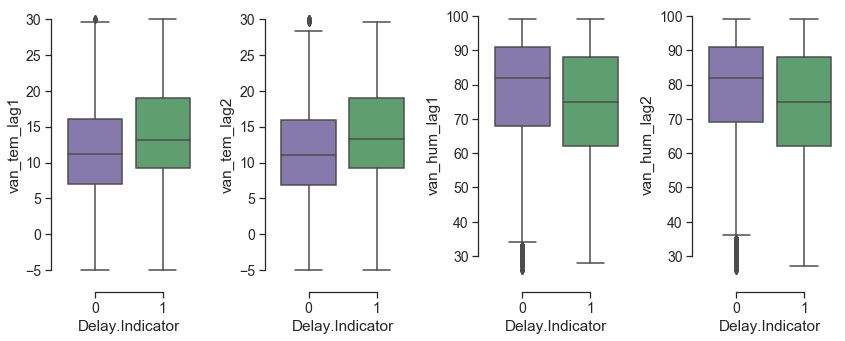

In [88]:
fig,axes = plt.subplots(1,4,figsize=(12,5))

sns.boxplot(x="Delay.Indicator", y="van_tem_lag1",
             palette=["m", "g"],
            data=train1,ax = axes[0])
sns.boxplot(x="Delay.Indicator", y="van_tem_lag2",
             palette=["m", "g"],
            data=train1,ax = axes[1])
sns.boxplot(x="Delay.Indicator", y="van_hum_lag1",
             palette=["m", "g"],
            data=train1,ax = axes[2])
sns.boxplot(x="Delay.Indicator", y="van_hum_lag2",
             palette=["m", "g"],
            data=train1,ax = axes[3])

sns.despine(offset=10, trim=True)

plt.tight_layout()

## Victoria

In [112]:
victoria.dropna(axis=0,inplace = True)

In [102]:
## temperature lags
victoria['vic_tem_lag1'] = victoria['InterpolateQuadratic_Tem'].shift(1)
victoria['vic_tem_lag2'] = victoria['InterpolateQuadratic_Tem'].shift(2)

## Dew.Point lags
victoria['vic_dew_lag1'] = victoria['InterpolateCubic_Dew'].shift(1)
victoria['vic_dew_lag2'] = victoria['InterpolateCubic_Dew'].shift(2)

## Relative.Humidity lags
victoria['vic_hum_lag1'] = victoria['InterpolateCubic_Humi'].shift(1)
victoria['vic_hum_lag2'] = victoria['InterpolateCubic_Humi'].shift(2)

## press lags
victoria['vic_press_lag1'] = victoria['InterpolateCubic_Press'].shift(1)
victoria['vic_press_lag2'] = victoria['InterpolateCubic_Press'].shift(2)

In [103]:
victoria.dropna(axis=0,inplace=True)

In [104]:
victoria_merge = victoria.iloc[:,[0,7,9,10,11,12,13,14,15,16,17,18,19]]

In [109]:
victoria_merge.set_index("Date.Time",inplace = True)
train1 = train1.merge(victoria_merge,left_index = True, right_index = True,how = "left")

In [110]:
test1 = test1.merge(victoria_merge,left_index = True, right_index = True,how = "left")

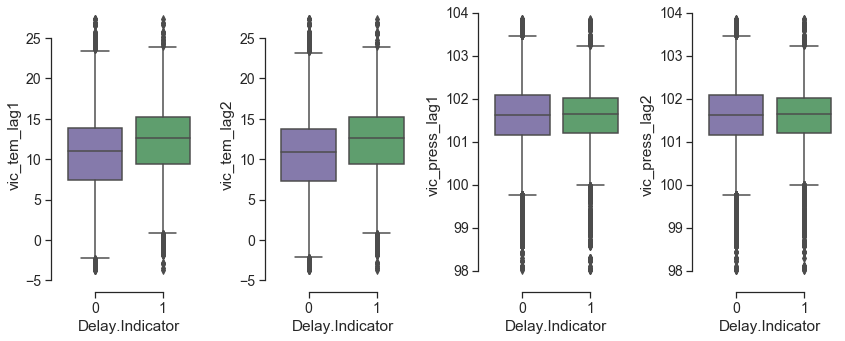

In [113]:
fig,axes = plt.subplots(1,4,figsize=(12,5))

sns.boxplot(x="Delay.Indicator", y="vic_tem_lag1",
             palette=["m", "g"],
            data=train1,ax = axes[0])
sns.boxplot(x="Delay.Indicator", y="vic_tem_lag2",
             palette=["m", "g"],
            data=train1,ax = axes[1])
sns.boxplot(x="Delay.Indicator", y="vic_press_lag1",
             palette=["m", "g"],
            data=train1,ax = axes[2])
sns.boxplot(x="Delay.Indicator", y="vic_press_lag2",
             palette=["m", "g"],
            data=train1,ax = axes[3])

sns.despine(offset=10, trim=True)

plt.tight_layout()


## Traffic

Text(0, 0.5, 'Traffic level')

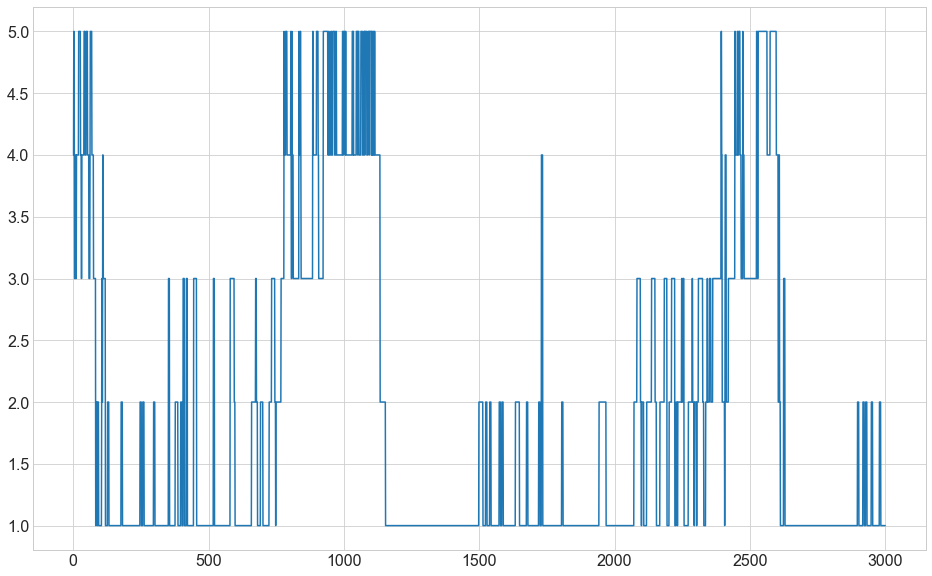

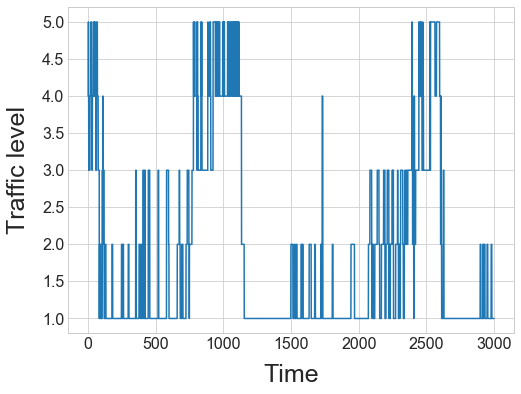

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(traffic.loc[1:3000,"Traffic.Ordinal"].index,traffic.loc[1:3000,"Traffic.Ordinal"])
ax.set_xlabel("Time",size = 25,labelpad=12)
ax.set_ylabel("Traffic level",size = 25,labelpad=12)

In [115]:
traffic["Date"] = pd.to_datetime(traffic["Date"])
traffic.set_index("Date",inplace=True)

### Extracting the traffic features

In [117]:
## traffic feature extration for train
train["lag1"] = train["Date_time"].apply(lambda x:lag1_mean(x))
train["lag2"] = train["Date_time"].apply(lambda x:lag2_mean(x))
train["lag3"] = train["Date_time"].apply(lambda x:lag3_mean(x))
train["lag4"] = train["Date_time"].apply(lambda x:lag4_mean(x))

In [119]:
## traffic feature extration for test
test1["lag1"] = test1["Date_time"].apply(lambda x:lag1_mean(x))
test1["lag2"] = test1["Date_time"].apply(lambda x:lag2_mean(x))
test1["lag3"] = test1["Date_time"].apply(lambda x:lag3_mean(x))
test1["lag4"] = test1["Date_time"].apply(lambda x:lag4_mean(x))

In [75]:
lag_index = train.loc[train["lag4"].isna(),"Date_time"] +pd.Timedelta(days=1)

In [76]:
train_impute = train.loc[train["Date_time"].isin(lag_index),["Date_time","lag1","lag2","lag3","lag4"]].groupby("Date_time").mean()

In [77]:
train_impute 

,lag1,lag2,lag3,lag4,lag5
Date_time,,,,,
2016-08-29 05:15:00,1.0,1.0,1.0,1.0,1.0
2016-08-29 06:00:00,1.0,1.0,1.0,1.0,1.0
2016-08-29 06:20:00,1.0,1.0,1.0,1.0,1.0
2016-08-29 07:00:00,1.0,1.0,1.0,1.0,1.0
2016-08-29 07:25:00,1.0,1.0,1.0,1.0,1.0
2016-08-29 07:45:00,1.0,1.0,1.0,1.0,1.0


In [78]:
lag_in_1 = train.loc[train["lag1"].isna(),:].index
lag_in_2 = train.loc[train["lag4"].isna(),:].index

In [79]:
## Since lag1 and lag2 before 7:25 are 1.0, we decided to impute all mising lag1 and lag2 with 1.0
train.loc[lag_in_1,"lag1"] = 1.0
train.loc[lag_in_1,"lag2"] = 1.0
train.loc[lag_in_1,"lag3"] = 1.0
train.loc[lag_in_2,'lag4'] = 1.0
train["Delay.Indicator"] = train["Delay.Indicator"].astype('category')

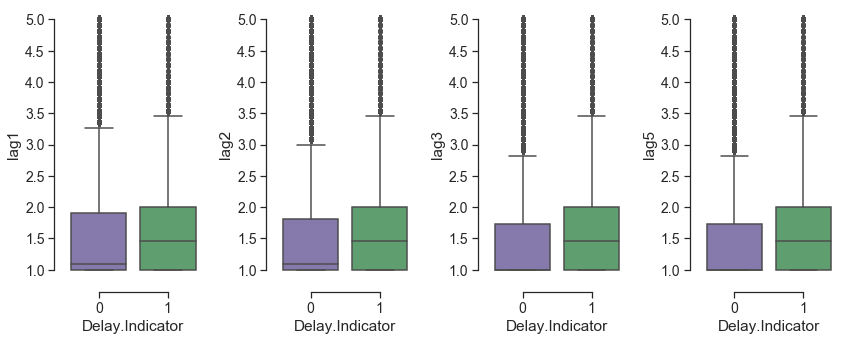

In [83]:
fig,axes = plt.subplots(1,4,figsize=(12,5))

sns.boxplot(x="Delay.Indicator", y="lag1",
             palette=["m", "g"],
            data=train,ax = axes[0])
sns.boxplot(x="Delay.Indicator", y="lag2",
             palette=["m", "g"],
            data=train,ax = axes[1])
sns.boxplot(x="Delay.Indicator", y="lag3",
             palette=["m", "g"],
            data=train,ax = axes[2])
sns.boxplot(x="Delay.Indicator", y="lag5",
             palette=["m", "g"],
            data=train,ax = axes[3])

sns.despine(offset=10, trim=True)

plt.tight_layout()

In [265]:
train.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\traffic_clean2.csv", index = True)

In [123]:
test1.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\test_clean2.csv", index = True)

In [177]:
## Final
train1.to_csv(r"C:\Users\xfu3\Desktop\Ferry project\train1.csv", index = True)